#### Импорт библиотек

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

#### Декоратор для подсчёта времени работы методов

In [2]:
def TimeDecorator(function):
    def Wrapper(*args, **kwargs):
        print('Start of function %s from ' % function.__name__ )
        start = time.perf_counter()
        z = function(*args, **kwargs)
        end = float(time.perf_counter() - start)
        print('Calculations took %.2e s.' % end)
        return z
    return Wrapper

#### Родительский класс для солверов

In [3]:
class DAESolver:
    def __init__(self):
        super().__init__()
        print('A %s solver initialized.' % self.__class__.__name__)
    
    def SetRightHandSide(self, function):
        self.RightHandSideFunction = function
    
    def SetInitialCondition(self, initialCondition):
        self._initialCondition = initialCondition

    def SetTimeGrid(self, numTimeBlocks, tStart, tEnd):
        self._numTimeBlocks, self._numTimePoints = numTimeBlocks, numTimeBlocks + 1
        self._tStart, self._tEnd = tStart, tEnd
        self._dt = float(self._tEnd - self._tStart)/float(self._numTimeBlocks)
        self._timeArray = np.linspace(self._tStart, self._tEnd, self._numTimePoints)

    @property
    def _Print(self):
        print('Step #%d completed.' % (self._tcounter))
        pass
    
    @property
    def SetSolutionArray(self):
        self._solutionArray = np.zeros(self._numTimePoints)
        self._solutionArray[0] = self._initialCondition
    
    @property
    @TimeDecorator
    def Solve(self):
        self.SetSolutionArray
        self.TimeStepping
        return self._solutionArray, self._timeArray
    
    @property
    def TimeStepping(self):
        self._tcounter = 0
        for i in range(self._numTimeBlocks):
            self.PredictValue
            self._tcounter += 1
            self._Print
            
    @property
    def PredictValue(self):
        raise NotImplementedError('Method DAESolver.PredictValue is pure virtual')

#### Модификация класса для системы уравнений

In [4]:
class SDAESolver(DAESolver):
    def __init__(self):
        super().__init__()
    
    def SetBoundaryConditions(self, leftXCondition, rightXCondition):
        self._leftXCondition = leftXCondition
        self._rightXCondition = rightXCondition
    
    def SetCoordinateGrid(self, numXBlocks, xStart, xEnd):
        self._numXBlocks, self._numXPoints = numXBlocks, numXBlocks + 1
        self._xStart, self._xEnd = xStart, xEnd
        self._dx = float(self._xStart - self._xEnd)/float(self._numXBlocks)
        self._xArray = np.linspace(self._xStart, self._xEnd, self._numXPoints)
        
    def SetKappa(self, kappa):
        self._kappa = kappa
    
    @property
    def SetSolutionArray(self):
        self._solutionArray = np.zeros((self._numTimePoints, self._numXPoints))
        self._solutionArray[0] = self._initialCondition(self._xArray)
        for i, x in enumerate(self._timeArray):
            self._solutionArray[i][0] = self._leftXCondition
            self._solutionArray[i][-1] = self._rightXCondition
            
    @property
    def TimeStepping(self):
        self._tcounter = 0
        for i in range(self._numTimeBlocks):
            self.PredictValue
            self._tcounter += 1
    
    #1 Так как формула подсчёта использует граничные условия, то функция правой части захардкожена тут
    # Хоть приводить матрицу системы к диагональному виду не требуется, так удобней.
    def RightHandSideFunction(self, u):
        F = np.zeros(u.__len__())
        F[0], F[-1] = self._leftXCondition, self._rightXCondition
        A = np.zeros((u.__len__(), u.__len__()))
        np.fill_diagonal(A, -2)
        np.fill_diagonal(A[1:], 1)
        np.fill_diagonal(A[:, 1:], 1)
        return self._kappa / self._dx**2 * (A @ u + F)

#### Реализация методов

In [5]:
class SExplicitEuler(SDAESolver):
    @property
    def PredictValue(self):
        i, u, dt, f = self._tcounter, self._solutionArray, self._dt, self.RightHandSideFunction
        u[i + 1] = u[i] + dt*f(u[i])

In [6]:
class SHeun(SDAESolver):
    @property
    def PredictValue(self):
        i, u, dt, f = self._tcounter, self._solutionArray, self._dt, self.RightHandSideFunction
        uStar = u[i] + dt*f(u[i])
        u[i + 1] = u[i] + dt/2.*(f(u[i]) + f(uStar))

In [7]:
class SRK4(SDAESolver):
    @property
    def PredictValue(self):
        i, u, dt, f = self._tcounter, self._solutionArray, self._dt, self.RightHandSideFunction
        k1 = f(u[i])
        k2 = f(u[i] + dt/2.*k1)
        k3 = f(u[i] + dt/2.*k2)
        k4 = f(u[i] + dt*k3)
        u[i + 1] = u[i] + dt/6. * (k1 + 2.*k2 + 2.*k3 + k4)

#### Начальные условия

In [8]:
def U0(vec):
    ans = []
    for arg in vec:        
        if arg<0:
            raise NotImplementedError('Out of range')
        if arg>1:
            raise NotImplementedError('Out of range')
        if 0.4<=arg<=0.6:
            ans = ans + [1]
        else:
            ans = ans + [0]
    return ans

#### Функция правой части

In [9]:
#2 Работает корректно ТОЛЬКО для задачи с нулевыми граничными условиям, см. #1.
class RightHandSideFunction:
    
    def __init__(self, kappa=0.1, h=1/25):
        self.SetKappa(kappa)
        self.SetH(h)
        
    def SetKappa(self, kappa):
        self._kappa = float(kappa)
        
    def SetH(self, h):
        self._h = float(h)
    
    def __call__(self, u):
        F = np.zeros(u.__len__())
        # F[0], F[-1] = self._leftXCondition, self._rightXCondition
        A = np.zeros((u.__len__(), u.__len__()))
        np.fill_diagonal(A, -2)
        np.fill_diagonal(A[1:], 1)
        np.fill_diagonal(A[:, 1:], 1)
        return self._kappa / self._h**2 * (A @ u + F)

#### График

A SExplicitEuler solver initialized.
Start of function Solve from 
Calculations took 3.58e-01 s.
A SHeun solver initialized.
Start of function Solve from 
Calculations took 9.70e-01 s.
A SRK4 solver initialized.
Start of function Solve from 
Calculations took 1.39e+00 s.


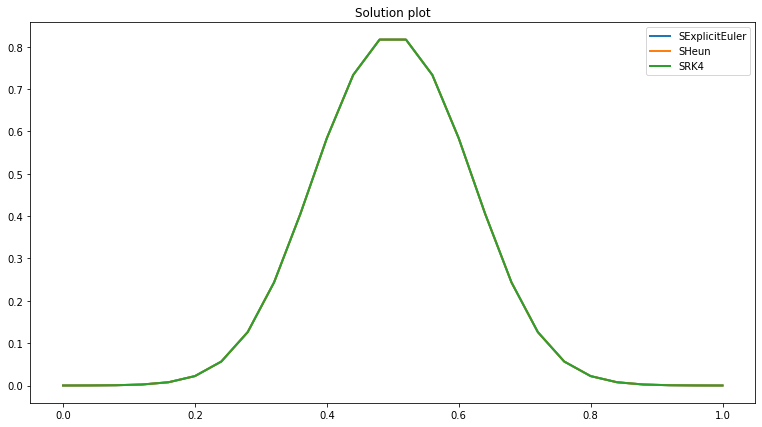

In [10]:
kappa = 0.1
h = 1/25

plt.figure(figsize=(13,7))
plt.title('Solution plot')

listOfMethods = [SExplicitEuler, SHeun, SRK4]

for method in listOfMethods:
    solver = method()
    solver.SetInitialCondition(U0)
    # Расскоментировать следующую строку для внешней функции правой части вместо внутренней.
    #2 solver.SetRightHandSide(RightHandSideFunction(kappa, h))
    solver.SetBoundaryConditions(0, 0)
    solver.SetKappa(kappa)
    solver.SetCoordinateGrid(int(1/h), 0, 1)
    solver.SetTimeGrid(int(200*kappa/h**2), 0, 0.04)
    SA,TA = solver.Solve
    plt.plot(solver._xArray, SA[-1], linewidth=2, label=solver.__class__.__name__)

plt.legend()
plt.show()

A SExplicitEuler solver initialized.
Start of function Solve from 
Calculations took 3.73e-01 s.
A SHeun solver initialized.
Start of function Solve from 
Calculations took 9.86e-01 s.
A SRK4 solver initialized.
Start of function Solve from 
Calculations took 1.45e+00 s.


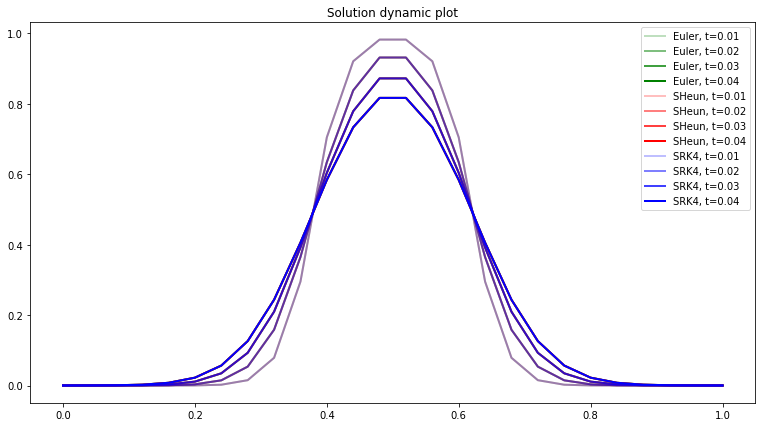

In [11]:
from enum import Enum
class PlotColour(Enum):
    green = 1
    red = 2
    blue = 3
    
numPlots=4

h = 1/25
kappa = 0.1

listOfMethods = [SExplicitEuler, SHeun, SRK4]
plt.figure(figsize=(13,7))
plt.title('Solution dynamic plot')
for k, method in enumerate(listOfMethods):
    solver = method()
    solver.SetInitialCondition(U0)
    solver.SetBoundaryConditions(0, 0)
    solver.SetKappa(kappa)
    solver.SetCoordinateGrid(int(1/h), 0, 1)
    solver.SetTimeGrid(int(200*kappa/h**2), 0, 0.04)
    #2 solver.SetRightHandSide(RightHandSideFunction(kappa, h))
    SA,TA = solver.Solve
    for i in range(numPlots):
        proc = (i+1)/numPlots
        tAbs = str(proc*solver._tEnd)
        tArr = int((SA.shape[0]-1)*proc)
        name = solver.__class__.__name__[-5:]+', t='+tAbs
        plt.plot(solver._xArray, SA[tArr], color=PlotColour(k+1).name, linewidth=2, alpha=proc,  label=name)

plt.legend(loc='best')
plt.show()